In [ ]:
# Standard libraries
import os
import sys
import warnings
warnings.filterwarnings("ignore")

# Data manipulation and analysis
import numpy as np
import pandas as pd

# Plotting
import matplotlib.pyplot as plt
import powerlaw as pl

# Statistics and modeling
from scipy import stats
from sklearn.metrics import *
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

# Get the current working directory and then go up to the parent directory
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the parent directory to sys.path
sys.path.append(parent_dir)

## Calibration on Data for AMZN Stock on 2024-08-12

In [12]:
# message_data = pd.read_csv("_data_dwn_43_456__AMZN_2024-08-01_2024-08-01_10/AMZN_2024-08-01_24900000_57900000_message_10.csv", header=None)
# message_data = pd.read_csv("AMZN_2012-06-21_34200000_57600000_message_10.csv", header=None)

message_data = pd.read_csv("combined_messages_2024-08-12.csv")

message_column_names = [
    'Time',         # Seconds after midnight with decimal precision
    'EventType',    # Type of event (1 to 7 as described)
    'OrderID',      # Unique order reference number
    'Size',         # Number of shares
    'Price',        # Dollar price times 10000
    'Direction',     # -1 for sell, 1 for buy
    # 'NotUsed',      # Not used, for alignment purposes
]

message_data.columns = message_column_names

print(message_data.shape)

# Drop first row
message_data = message_data.drop(0)

# Drop NotUsed column
# message_data = message_data.drop(columns=['NotUsed'])

message_data.head()

(1438228, 6)


,Time,EventType,OrderID,Size,Price,Direction
1,2024-08-12 09:30:00.049734400,1,25496857,200,1680000,1
2,2024-08-12 09:30:00.103421696,5,0,663,1681200,1
3,2024-08-12 09:30:00.114824448,5,0,20,1681200,1
4,2024-08-12 09:30:00.146436096,1,25566253,300,1681400,-1
5,2024-08-12 09:30:00.150553088,4,25496365,36,1681400,-1


In [13]:
# book_data = pd.read_csv("_data_dwn_43_456__AMZN_2024-08-01_2024-08-01_10/AMZN_2024-08-01_24900000_57900000_orderbook_10.csv", header=None)
# book_data = pd.read_csv("AMZN_2012-06-21_34200000_57600000_orderbook_10.csv", header=None)

book_data = pd.read_csv("combined_orderbooks_2024-08-12.csv")

# Define the column names up to level 10
column_names = []
for level in range(1, 11):
    column_names.extend([
        f'AskPrice{level}', f'AskSize{level}',
        f'BidPrice{level}', f'BidSize{level}'
    ])

# Set the column names for the DataFrame
book_data.columns = column_names

print(book_data.shape)

# Drop first row
book_data = book_data.drop(0)

book_data.head()

(1438228, 40)


,AskPrice1,AskSize1,BidPrice1,BidSize1,AskPrice2,AskSize2,BidPrice2,BidSize2,AskPrice3,AskSize3,...,BidPrice8,BidSize8,AskPrice9,AskSize9,BidPrice9,BidSize9,AskPrice10,AskSize10,BidPrice10,BidSize10
1,1681400,36,1680000,1112,1684000,200,1679900,72,1684100,89,...,1677000,211,1686000,200,1676600,1,1686800,156,1676500,5
2,1681400,36,1680000,1112,1684000,200,1679900,72,1684100,89,...,1677000,211,1686000,200,1676600,1,1686800,156,1676500,5
3,1681400,36,1680000,1112,1684000,200,1679900,72,1684100,89,...,1677000,211,1686000,200,1676600,1,1686800,156,1676500,5
4,1681400,336,1680000,1112,1684000,200,1679900,72,1684100,89,...,1677000,211,1686000,200,1676600,1,1686800,156,1676500,5
5,1681400,300,1680000,1112,1684000,200,1679900,72,1684100,89,...,1677000,211,1686000,200,1676600,1,1686800,156,1676500,5


In [14]:
# Directly copy the 'Time' column from message_data to book_data
book_data['Time'] = message_data['Time']

# Reorder columns to make 'Time' the first column
# This assumes book_data originally had unnamed columns
columns = ['Time'] + list(book_data.columns[:-1])  # Move 'Time' to the first position
book_data = book_data[columns]

message_data['Time'] = pd.to_datetime(message_data['Time'])
book_data['Time'] = pd.to_datetime(book_data['Time'])

message_data.set_index('Time', inplace=True)
book_data.set_index('Time', inplace=True)

### Invesigating MO intensity

In [15]:
# Define market order event types (executions)
market_order_types = [4, 5]  # Event Types 4 and 5 indicate executions

# Count the number of market orders in message_data
market_order_count = message_data[message_data['EventType'].isin(market_order_types)].shape[0]

# Calculate the total number of orders
total_orders = len(message_data)

# Calculate the percentage of market orders
market_order_percentage = (market_order_count / total_orders) * 100

print(f"Percentage of market orders {market_order_percentage:.4f}%")

Percentage of market orders 6.3402%


In [16]:
# Define the time interval for resampling
TIME_INTERVAL = '5S'

In [17]:
# Filter only for market orders (Event Types 4 and 5)
market_orders = message_data[message_data['EventType'].isin([4, 5])]

# Time cropping
market_orders = market_orders.between_time('10:40:00', '12:10:00')

full_time_index = pd.date_range(start=market_orders.index.min().floor(TIME_INTERVAL),
                                end=market_orders.index.max().floor(TIME_INTERVAL),
                                freq=TIME_INTERVAL)

# Corrected split into buy and sell market orders based on Direction
buy_market_order = market_orders[market_orders['Direction'] == -1]  # Buyer-initiated trade (buy market order)
sell_market_order = market_orders[market_orders['Direction'] == 1]  # Seller-initiated trade (sell market order)



In [18]:
# Group by minute and count the number of buy orders
buy_market_order_minutely = buy_market_order.groupby(buy_market_order.index.floor(TIME_INTERVAL)).size()

# Group by minute and count the number of sell orders
sell_market_order_minutely = sell_market_order.groupby(sell_market_order.index.floor(TIME_INTERVAL)).size()

# Calculate cumulative count (cumulative sum) for each minute
Mt_plus = buy_market_order_minutely.cumsum()  # Cumulative count of buy market orders
Mt_minus = sell_market_order_minutely.cumsum()  # Cumulative count of sell market orders

Mt_plus = Mt_plus.reindex(full_time_index, method='ffill')
Mt_minus = Mt_minus.reindex(full_time_index, method='ffill')

print("Mt_plus: ", Mt_plus.shape)
print("Mt_minus: ", Mt_minus.shape)

# EXAMPLE: examine first three entries for sell_market_order_minutely
print("Mt mimus (cumulative, number of orders):")
print(Mt_minus.head(3))


Mt_plus:  (1080,)
Mt_minus:  (1080,)
Mt mimus (cumulative, number of orders):
2024-08-12 10:40:00     5
2024-08-12 10:40:05    21
2024-08-12 10:40:10    21
Freq: 5S, dtype: int64


In [19]:
# Group by minute and count the number of buy orders
buy_market_order_intensity = buy_market_order.groupby(buy_market_order.index.floor(TIME_INTERVAL))['Size'].sum()

# Group by minute and count the number of sell orders
sell_market_order_intensity = sell_market_order.groupby(sell_market_order.index.floor(TIME_INTERVAL))['Size'].sum()

# Reindex buy and sell series to fill in missing minutes with 0 orders
buy_market_order_intensity = buy_market_order_intensity.reindex(full_time_index, fill_value=0)
sell_market_order_intensity = sell_market_order_intensity.reindex(full_time_index, fill_value=0)

print("Buy Market Order Intensity: ", buy_market_order_intensity.shape)
print("Sell Market Order Intensity: ", sell_market_order_intensity.shape)

print("Sell Market Order Intensity (not cumulative, number of shares) :")
print(sell_market_order_intensity.head(3))


Buy Market Order Intensity:  (1080,)
Sell Market Order Intensity:  (1080,)
Sell Market Order Intensity (not cumulative, number of shares) :
2024-08-12 10:40:00     208
2024-08-12 10:40:05    1340
2024-08-12 10:40:10       0
Freq: 5S, Name: Size, dtype: int64


Calculating best minimal value for power law fit
Calculating best minimal value for power law fit


Values less than or equal to 0 in data. Throwing out 0 or negative values
Values less than or equal to 0 in data. Throwing out 0 or negative values


Alpha for buy market order intensity:  2.6930622646081646
Alpha for sell market order intensity:  2.642281413143671


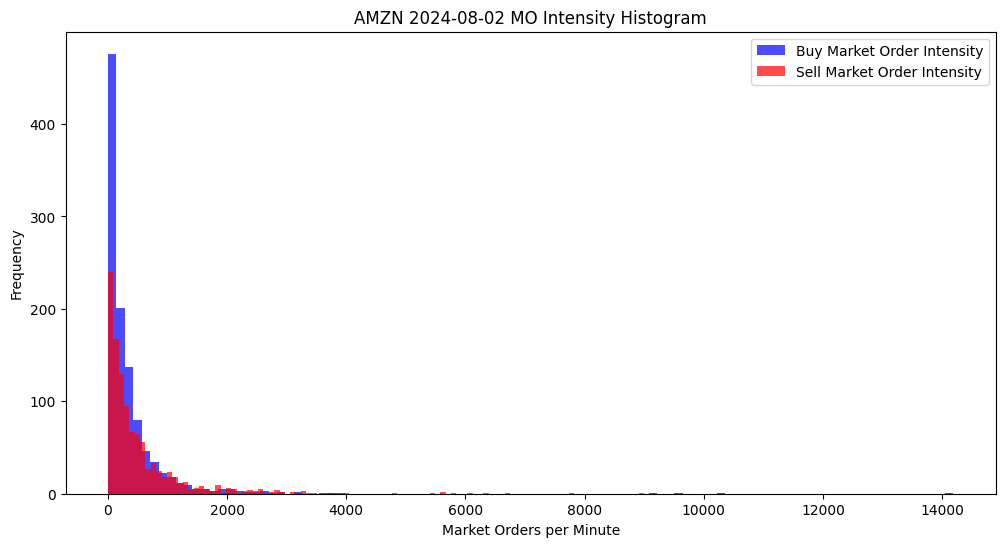

In [20]:
# visualize the histogram of the buy and sell market order intensity
plt.figure(figsize=(12, 6))
plt.hist(buy_market_order_intensity, bins=100, color='blue', alpha=0.7, label='Buy Market Order Intensity')
plt.hist(sell_market_order_intensity, bins=100, color='red', alpha=0.7, label='Sell Market Order Intensity')

# Find the power law alpha for buy market order intensity
fit_buy = pl.Fit(buy_market_order_intensity, discrete=True)
alpha_buy = fit_buy.alpha

fit_sell = pl.Fit(sell_market_order_intensity, discrete=True)
alpha_sell = fit_sell.alpha

print("Alpha for buy market order intensity: ", alpha_buy)
print("Alpha for sell market order intensity: ", alpha_sell)


plt.xlabel('Market Orders per Minute')  
plt.ylabel('Frequency')
plt.title('AMZN 2024-08-02 MO Intensity Histogram')
plt.legend()
plt.show()


Buy Market Order Intensity:
  Estimated xmin: 733.0
  Power law alpha: 2.6950
  KS (Power law): 0.0367
  KS (Exponential): 0.1644
  Log-likelihood ratio R = 22.28, p = 0.0382

Sell Market Order Intensity:
  Estimated xmin: 778.0
  Power law alpha: 2.6440
  KS (Power law): 0.0545
  KS (Exponential): 0.1168
  Log-likelihood ratio R = 10.41, p = 0.1578


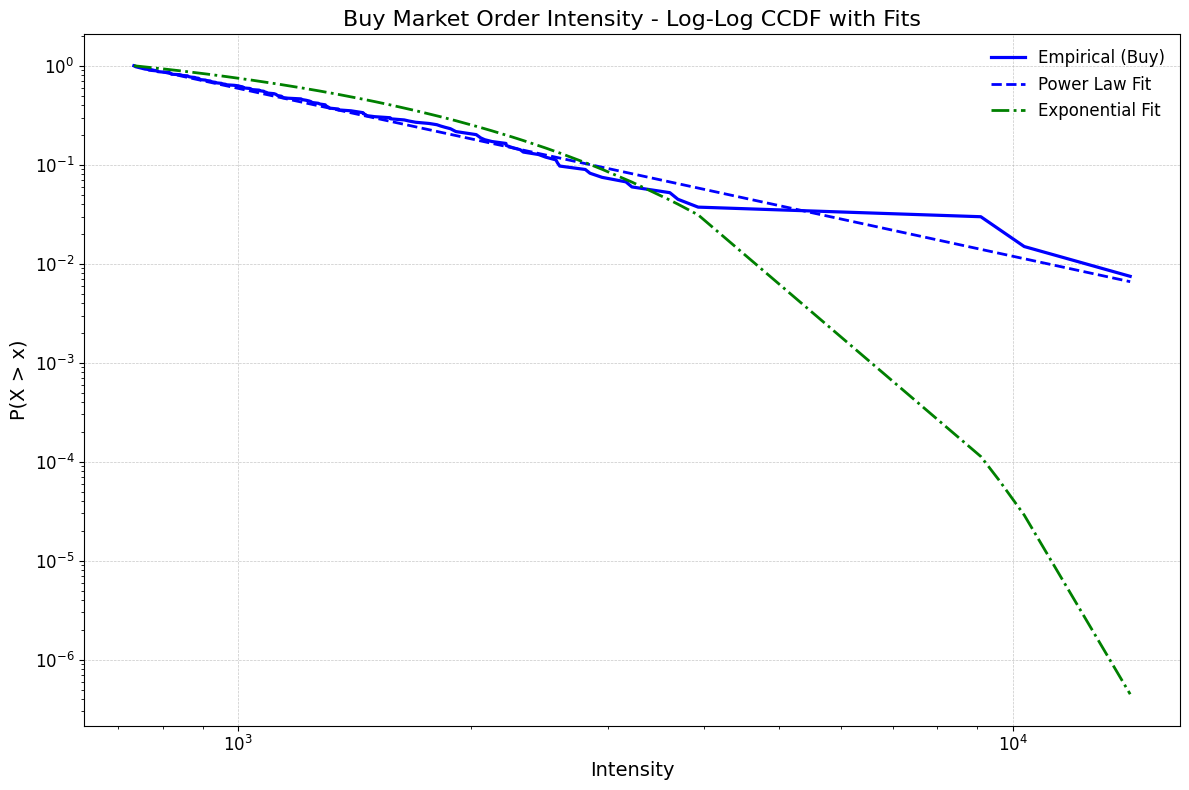

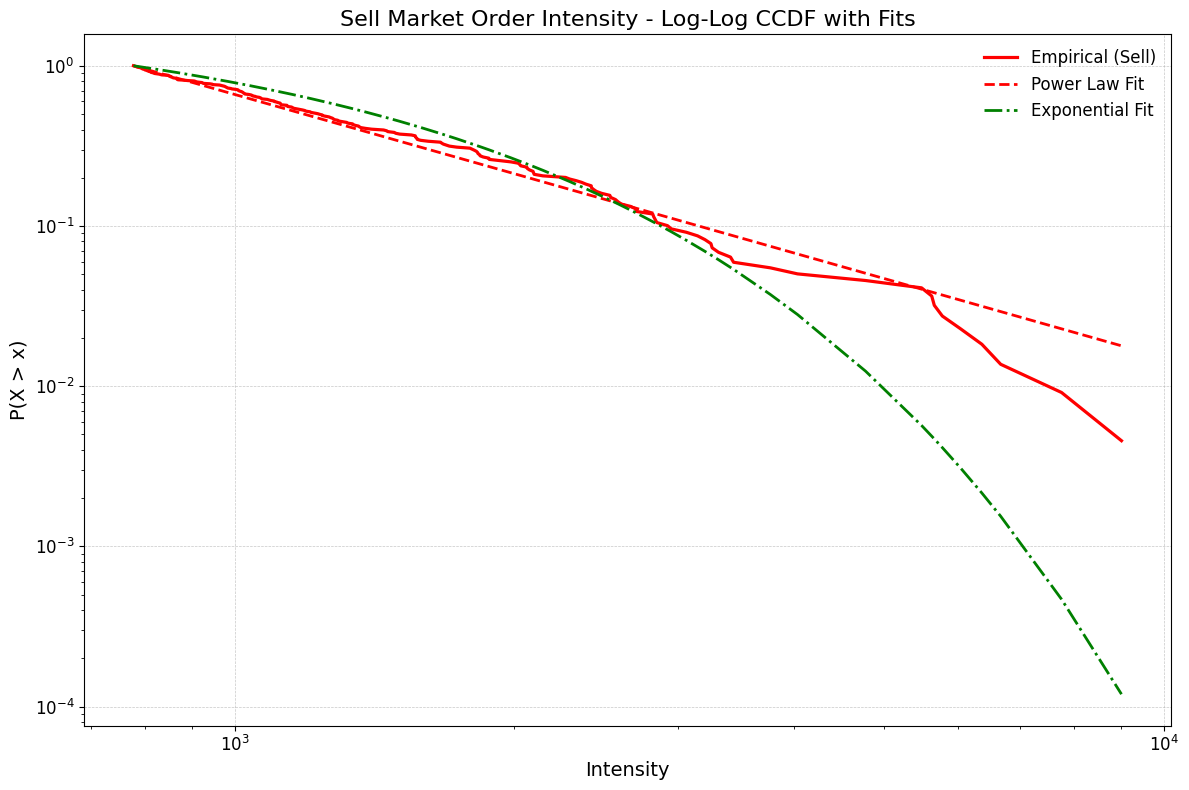

In [21]:
# Fit the models
fit_buy = pl.Fit(buy_market_order_intensity, verbose=False)
fit_sell = pl.Fit(sell_market_order_intensity, verbose=False)

# KS statistics
ks_buy = fit_buy.power_law.KS()
ks_exp_buy = fit_buy.exponential.KS()

ks_sell = fit_sell.power_law.KS()
ks_exp_sell = fit_sell.exponential.KS()

# Likelihood ratio tests
R_buy, p_buy = fit_buy.distribution_compare('power_law', 'exponential')
R_sell, p_sell = fit_sell.distribution_compare('power_law', 'exponential')

# Print results
print("Buy Market Order Intensity:")
print(f"  Estimated xmin: {fit_buy.xmin}")
print(f"  Power law alpha: {fit_buy.alpha:.4f}")
print(f"  KS (Power law): {ks_buy:.4f}")
print(f"  KS (Exponential): {ks_exp_buy:.4f}")
print(f"  Log-likelihood ratio R = {R_buy:.2f}, p = {p_buy:.4f}")

print("\nSell Market Order Intensity:")
print(f"  Estimated xmin: {fit_sell.xmin}")
print(f"  Power law alpha: {fit_sell.alpha:.4f}")
print(f"  KS (Power law): {ks_sell:.4f}")
print(f"  KS (Exponential): {ks_exp_sell:.4f}")
print(f"  Log-likelihood ratio R = {R_sell:.2f}, p = {p_sell:.4f}")

# Plot: Buy
fig, ax = plt.subplots(figsize=(12, 8))

# Plot CCDF and fits for Buy
fit_buy.plot_ccdf(color='blue', label='Empirical (Buy)', ax=ax, linewidth=2.3)
fit_buy.power_law.plot_ccdf(color='blue', linestyle='--', label='Power Law Fit', ax=ax, linewidth=2)
fit_buy.exponential.plot_ccdf(color='green', linestyle='-.', label='Exponential Fit', ax=ax, linewidth=2)

# Styling
ax.set_title("Buy Market Order Intensity - Log-Log CCDF with Fits", fontsize=16)
ax.set_xlabel("Intensity", fontsize=14)
ax.set_ylabel(r"P(X > x)", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Legend
ax.legend(fontsize=12, loc='best', frameon=False)

plt.tight_layout()
plt.show()

# Plot: Sell
fig, ax = plt.subplots(figsize=(12, 8))

# Plot CCDF and fits for Sell
fit_sell.plot_ccdf(color='red', label='Empirical (Sell)', ax=ax, linewidth=2.3)
fit_sell.power_law.plot_ccdf(color='red', linestyle='--', label='Power Law Fit', ax=ax, linewidth=2)
fit_sell.exponential.plot_ccdf(color='green', linestyle='-.', label='Exponential Fit', ax=ax, linewidth=2)

# Styling
ax.set_title("Sell Market Order Intensity - Log-Log CCDF with Fits", fontsize=16)
ax.set_xlabel("Intensity", fontsize=14)
ax.set_ylabel(r"P(X > x)", fontsize=14)
ax.set_xscale('log')
ax.set_yscale('log')
ax.tick_params(axis='both', which='major', labelsize=12)
ax.grid(True, which='major', linestyle='--', linewidth=0.5, alpha=0.7)

# Legend
ax.legend(fontsize=12, loc='best', frameon=False)

plt.tight_layout()
plt.show()



### Model Calibration

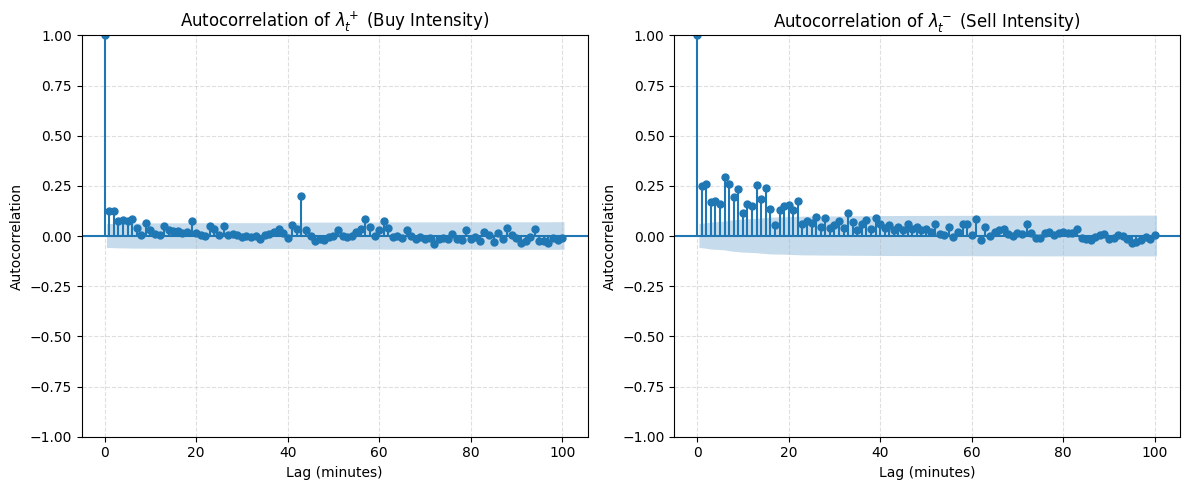

In [22]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

plot_acf(buy_market_order_intensity, ax=axes[0], lags=100, title="Autocorrelation of $\lambda^+_t$ (Buy Intensity)")
plot_acf(sell_market_order_intensity, ax=axes[1], lags=100, title="Autocorrelation of $\lambda^-_t$ (Sell Intensity)")

for ax in axes:
    ax.set_ylim(-1, 1)
    ax.set_xlabel("Lag (minutes)")
    ax.set_ylabel("Autocorrelation")
    ax.grid(True, linestyle='--', alpha=0.4)

plt.tight_layout()
plt.show()


In [23]:
# Calculate the difference between consecutive values for the dependent variable
buy_intensity_diff = buy_market_order_intensity.diff().dropna()
sell_intensity_diff = sell_market_order_intensity.diff().dropna()

# Calculate differences in Mt_plus and Mt_minus for independent variables
Mt_plus_diff = Mt_plus.diff().dropna()
Mt_minus_diff = Mt_minus.diff().dropna()

In [24]:
# Define the percentile limits for Winsorization
lower_percentile = 0
upper_percentile = 80

# Function to Winsorize a series in-place
def winsorize_series(series, lower_percentile, upper_percentile):
    lower_cap = np.percentile(series, lower_percentile)
    upper_cap = np.percentile(series, upper_percentile)
    return np.clip(series, lower_cap, upper_cap)

# Calculate the difference between consecutive values and drop NaNs
buy_intensity_diff = buy_market_order_intensity.diff().dropna()
sell_intensity_diff = sell_market_order_intensity.diff().dropna()
Mt_plus_diff = Mt_plus.diff().dropna()
Mt_minus_diff = Mt_minus.diff().dropna()

In [25]:
print("==========BUY INTENSITY AIC/BIC DIFF==========")

y = buy_intensity_diff.values

# AIC examination
# It will contain for each model a tuple of (name, number of parameters, AIC value)
aic_values = []

# Model 1: constant + intensity
X1 = sm.add_constant(buy_market_order_intensity[:-1].values)
model1 = sm.GLS(y, X1).fit()

aic_values.append(('Model 1 (constant + intensity) ', 2, model1.aic))

# Model 2: constant + intensity + Mt_plus
X2 = sm.add_constant(np.column_stack((buy_market_order_intensity[:-1].values, Mt_plus_diff.values)))
model2 = sm.GLS(y, X2).fit()

aic_values.append(('Model 2 (constant + intensity + Mt_plus) ', 3, model2.aic))

# Model 3: constant + intensity + Mt_minus
X3 = sm.add_constant(np.column_stack((buy_market_order_intensity[:-1].values, Mt_minus_diff.values)))
model3 = sm.GLS(y, X3).fit()

aic_values.append(('Model 3 (constant + intensity + Mt_minus) ', 3, model3.aic))

# Model 4: constant + intensity + Mt_plus + Mt_minus
X4 = sm.add_constant(np.column_stack((buy_market_order_intensity[:-1].values, Mt_plus_diff.values, Mt_minus_diff.values)))
model4 = sm.GLS(y, X4).fit()

aic_values.append(('Model 4 (constant + intensity + Mt_plus + Mt_minus) ', 4, model4.aic))

# Calculate AIC differences
aic_diffs = np.array([aic - min([model1.aic, model2.aic, model3.aic, model4.aic]) for name, params, aic in aic_values])

# Append the AIC differences to the aic_values list
for i, (name, params, aic) in enumerate(aic_values):
    aic_values[i] = (name, params, aic, aic_diffs[i])

# Display the AIC values for each model
print("AIC values for each model:")
for name, params, aic, diff in aic_values:
    print(f"{name} | With {params} params | AIC:{aic:.4f} | Diff:{diff:.4f}")

# BIC, where overfitting is penalized more than AIC
# It will contain for each model a tuple of (name, number of parameters, BIC value)

bic_values = []

# Model 1: constant + intensity
bic_values.append(('Model 1 (constant + intensity) ', 2, model1.bic))

# Model 2: constant + intensity + Mt_plus
bic_values.append(('Model 2 (constant + intensity + Mt_plus) ', 3, model2.bic))

# Model 3: constant + intensity + Mt_minus
bic_values.append(('Model 3 (constant + intensity + Mt_minus) ', 3, model3.bic))

# Model 4: constant + intensity + Mt_plus + Mt_minus
bic_values.append(('Model 4 (constant + intensity + Mt_plus + Mt_minus) ', 4, model4.bic))

# Calculate BIC differences
bic_diffs = np.array([bic - min([model1.bic, model2.bic, model3.bic, model4.bic]) for name, params, bic in bic_values])

# Append the BIC differences to the bic_values list
for i, (name, params, bic) in enumerate(bic_values):
    bic_values[i] = (name, params, bic, bic_diffs[i])

# Display the BIC values for each model
print("\nBIC values for each model:")
for name, params, bic, diff in bic_values:
    print(f"{name} | With {params} params | BIC:{bic:.4f} | Diff:{diff:.4f}")

print("Number of observations: ", len(y))

==========BUY INTENSITY AIC/BIC DIFF==========
AIC values for each model:
Model 1 (constant + intensity)  | With 2 params | AIC:17501.5063 | Diff:430.0938
Model 2 (constant + intensity + Mt_plus)  | With 3 params | AIC:17076.9622 | Diff:5.5497
Model 3 (constant + intensity + Mt_minus)  | With 3 params | AIC:17411.7858 | Diff:340.3733
Model 4 (constant + intensity + Mt_plus + Mt_minus)  | With 4 params | AIC:17071.4125 | Diff:0.0000

BIC values for each model:
Model 1 (constant + intensity)  | With 2 params | BIC:17511.4739 | Diff:420.1262
Model 2 (constant + intensity + Mt_plus)  | With 3 params | BIC:17091.9136 | Diff:0.5659
Model 3 (constant + intensity + Mt_minus)  | With 3 params | BIC:17426.7372 | Diff:335.3895
Model 4 (constant + intensity + Mt_plus + Mt_minus)  | With 4 params | BIC:17091.3477 | Diff:0.0000
Number of observations:  1079


                            GLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.624
Model:                            GLS   Adj. R-squared:                  0.623
Method:                 Least Squares   F-statistic:                     595.8
Date:                Wed, 23 Apr 2025   Prob (F-statistic):          5.06e-228
Time:                        14:47:12   Log-Likelihood:                -8531.7
No. Observations:                1079   AIC:                         1.707e+04
Df Residuals:                    1075   BIC:                         1.709e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -79.4357     29.931     -2.654      0.0

/Users/user/opt/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:127: ValueWarning: unknown kwargs ['window']
  warnings.warn(msg, ValueWarning)


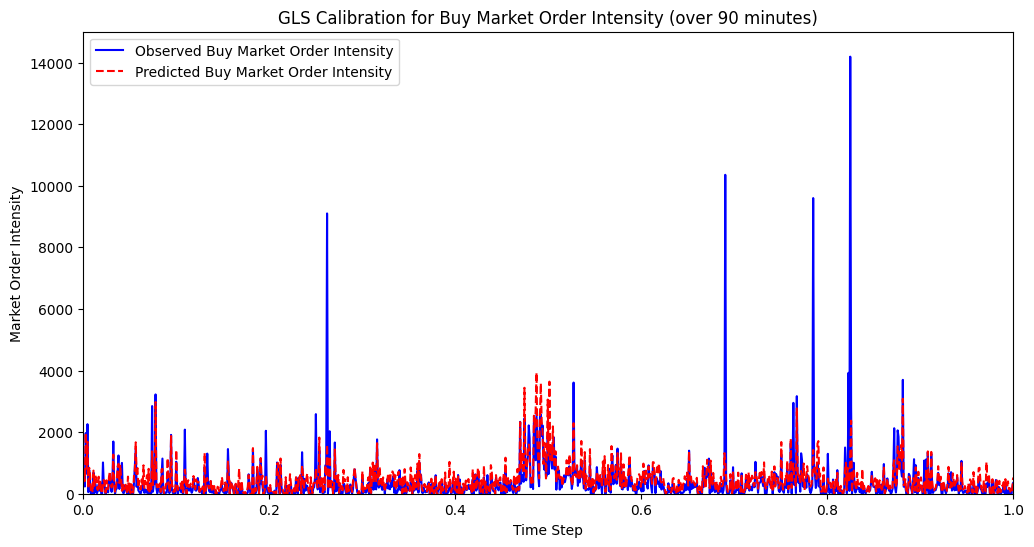

In [26]:
X = np.column_stack((
    buy_market_order_intensity[:-1].values,  # Buy intensity without the last value (to avoid lookahead bias)
    Mt_plus_diff.values,                     # Difference in Mt_plus
    Mt_minus_diff.values                     # Difference in Mt_minus
))

# Dependent variable
y = buy_intensity_diff.values

# Add a constant to the independent variables to include an intercept term in the model
X = sm.add_constant(X)

# Fit the model using statsmodels
model = sm.GLS(y, X, window=25)
results = model.fit()

print(results.summary())

# Explaination of model parameters
# Eta is self-excitation, assumed ro be 0 for now
# Nu is cross-excitation, assumed to be 0 for now
# Beta is the rate of mean reversion
# Theta is the baseline reverting level

# dt = 1 / len(buy_market_order_intensity)  # Time step
dt = 1/20
time_steps = len(buy_market_order_intensity)

# Calculate model parameters from the linear regression
buy_beta = results.params[1] / (dt * -1)
buy_theta = results.params[0] / buy_beta

buy_eta = results.params[2]
buy_nu = results.params[3]
# buy_nu = 0 # Not used in the model

# print(f"Beta: {buy_beta:.6f}, Theta: {buy_theta:.6f}")

# Display final parameter estimates
print(f"Final Parameter Estimates: buy_beta = {buy_beta:.4f}, buy_theta = {buy_theta:.4f}, buy_eta = {buy_eta:.4f}, buy_nu = {buy_nu:.4f}")

# Check assumption buy_beta > buy_eta + buy_nu
if buy_beta <= buy_eta + buy_nu:
    print("Invalid parameter values: buy_beta must be greater than buy_eta + buy_nu")
else:
    print("Valid parameter values: buy_beta is greater than buy_eta + buy_nu")

# Predict buy intensity using the calibrated parameters
lambda_buy_pred = np.zeros(time_steps)
lambda_buy_pred[0] = buy_market_order_intensity.mean()  # Initial condition from observed data

# Compute predicted buy intensities using the calibrated parameters over the observed time steps
for t in range(1, time_steps):
    lambda_buy_pred[t] = (lambda_buy_pred[t-1] + 
                          buy_beta * (buy_theta - lambda_buy_pred[t-1]) * dt + 
                          buy_eta * Mt_plus_diff.iloc[t-1] + 
                          buy_nu * Mt_minus_diff.iloc[t-1])

# Convert predicted intensities to a Series for easier plotting
lambda_buy_pred_series = pd.Series(lambda_buy_pred, index=buy_market_order_intensity.index)

# Normalize the time (the index) to [0, 1] for plotting, for both observed and predicted intensities
buy_market_order_intensity.index = (buy_market_order_intensity.index - buy_market_order_intensity.index.min()) / (buy_market_order_intensity.index.max() - buy_market_order_intensity.index.min())
lambda_buy_pred_series.index = (lambda_buy_pred_series.index - lambda_buy_pred_series.index.min()) / (lambda_buy_pred_series.index.max() - lambda_buy_pred_series.index.min())


# EXPERIMENT: plot only 20000 time steps starting at 20000
plt.figure(figsize=(12, 6))
plt.plot(buy_market_order_intensity, label='Observed Buy Market Order Intensity', color='blue')
plt.plot(lambda_buy_pred_series, label='Predicted Buy Market Order Intensity', color='red', linestyle='--')
plt.xlim(0, 1)
plt.ylim(0, 15000)
plt.xlabel('Time Step')
plt.ylabel('Market Order Intensity')
plt.title('GLS Calibration for Buy Market Order Intensity (over 90 minutes)')
plt.legend()

# Add r2 score to the plot
r2 = r2_score(buy_market_order_intensity, lambda_buy_pred_series)

plt.show()


In [27]:
print("==========SELL INTENSITY AIC/BIC DIFF==========")

y = sell_intensity_diff.values

# AIC examination
# It will contain for each model a tuple of (name, number of parameters, AIC value)
aic_values = []

# Model 1: constant + intensity
X1 = sm.add_constant(sell_market_order_intensity[:-1].values)
model1 = sm.GLS(y, X1).fit()

aic_values.append(('Model 1 (constant + intensity) ', 2, model1.aic))

# Model 2: constant + intensity + Mt_plus
X2 = sm.add_constant(np.column_stack((sell_market_order_intensity[:-1].values, Mt_plus_diff.values)))
model2 = sm.GLS(y, X2).fit()

aic_values.append(('Model 2 (constant + intensity + Mt_plus) ', 3, model2.aic))

# Model 3: constant + intensity + Mt_minus
X3 = sm.add_constant(np.column_stack((sell_market_order_intensity[:-1].values, Mt_minus_diff.values)))
model3 = sm.GLS(y, X3).fit()

aic_values.append(('Model 3 (constant + intensity + Mt_minus) ', 3, model3.aic))

# Model 4: constant + intensity + Mt_plus + Mt_minus
X4 = sm.add_constant(np.column_stack((sell_market_order_intensity[:-1].values, Mt_plus_diff.values, Mt_minus_diff.values)))
model4 = sm.GLS(y, X4).fit()

aic_values.append(('Model 4 (constant + intensity + Mt_plus + Mt_minus) ', 4, model4.aic))

# Calculate AIC differences
aic_diffs = np.array([aic - min([model1.aic, model2.aic, model3.aic, model4.aic]) for name, params, aic in aic_values])

# Append the AIC differences to the aic_values list
for i, (name, params, aic) in enumerate(aic_values):
    aic_values[i] = (name, params, aic, aic_diffs[i])

# Display the AIC values for each model
print("AIC values for each model:")
for name, params, aic, diff in aic_values:
    print(f"{name} | With {params} params | AIC:{aic:.4f} | Diff:{diff:.4f}")

# BIC, where overfitting is penalized more than AIC
# It will contain for each model a tuple of (name, number of parameters, BIC value)

bic_values = []

# Model 1: constant + intensity
bic_values.append(('Model 1 (constant + intensity) ', 2, model1.bic))

# Model 2: constant + intensity + Mt_plus
bic_values.append(('Model 2 (constant + intensity + Mt_plus) ', 3, model2.bic))

# Model 3: constant + intensity + Mt_minus
bic_values.append(('Model 3 (constant + intensity + Mt_minus) ', 3, model3.bic))

# Model 4: constant + intensity + Mt_plus + Mt_minus
bic_values.append(('Model 4 (constant + intensity + Mt_plus + Mt_minus) ', 4, model4.bic))

# Calculate BIC differences
bic_diffs = np.array([bic - min([model1.bic, model2.bic, model3.bic, model4.bic]) for name, params, bic in bic_values])

# Append the BIC differences to the bic_values list
for i, (name, params, bic) in enumerate(bic_values):
    bic_values[i] = (name, params, bic, bic_diffs[i])

# Display the BIC values for each model
print("\nBIC values for each model:")
for name, params, bic, diff in bic_values:
    print(f"{name} | With {params} params | BIC:{bic:.4f} | Diff:{diff:.4f}")

print("Number of observations: ", len(y))


==========SELL INTENSITY AIC/BIC DIFF==========
AIC values for each model:
Model 1 (constant + intensity)  | With 2 params | AIC:17504.1649 | Diff:1314.2532
Model 2 (constant + intensity + Mt_plus)  | With 3 params | AIC:17353.9980 | Diff:1164.0863
Model 3 (constant + intensity + Mt_minus)  | With 3 params | AIC:16207.7415 | Diff:17.8298
Model 4 (constant + intensity + Mt_plus + Mt_minus)  | With 4 params | AIC:16189.9117 | Diff:0.0000

BIC values for each model:
Model 1 (constant + intensity)  | With 2 params | BIC:17514.1325 | Diff:1304.2856
Model 2 (constant + intensity + Mt_plus)  | With 3 params | BIC:17368.9494 | Diff:1159.1025
Model 3 (constant + intensity + Mt_minus)  | With 3 params | BIC:16222.6929 | Diff:12.8460
Model 4 (constant + intensity + Mt_plus + Mt_minus)  | With 4 params | BIC:16209.8469 | Diff:0.0000
Number of observations:  1079
